Model training.
The model takes four inputs:
(i) and (ii) ESM-2.0–derived embeddings for the peptide and MHC sequences, and
(iii) and (iv) tokenized representations of the peptide and MHC sequences.

For a new dataset, ESM-2.0 features must first be generated using a separate embedding extraction script for both peptide and MHC sequences. Once these embeddings are obtained, the training code can be executed. To train the model on our dataset, the provided data files should be used.

In [1]:
import os
os.environ["CUDa_VISIBLE-DEVICES"] = "1" #  For GPU 

In [1]:
import random
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from tqdm import tqdm

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint
)

from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    Dense,
    Dropout,
    SpatialDropout1D,
    LayerNormalization,
    GlobalAveragePooling1D,
    GlobalMaxPooling1D,
    MultiHeadAttention,
    Add,
    Concatenate,
    Lambda,
    Activation,
    Layer
)

from tensorflow.keras.utils import Sequence
# Scikit-learn
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold
)
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.utils import (
    class_weight,
    resample,
    shuffle
)


2026-01-27 10:55:59.977339: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-27 10:56:00.038578: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-27 10:56:01.338717: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [9]:
print(tf.__version__) # tensorflow version

2.20.0


In [7]:
import keras

In [8]:
print(keras.__version__)

3.12.0


In [5]:
import sys
print(sys.version) # python version

3.11.14 | packaged by conda-forge | (main, Oct 22 2025, 22:46:25) [GCC 14.3.0]


In [18]:
data = pd.read_csv("Training_MHCII.csv") ## Main data file

In [19]:
data.columns

Index(['MHC_allele', 'Peptide', 'Immunogenicity', 'Sequence'], dtype='object')

In [20]:
data.head()

,MHC_allele,Peptide,Immunogenicity,Sequence
0,HLA-DRB1-0101,YLMDKLNLTKSDVQL,0,MVCLKLPGGSCMTALTVTLMVLSSPLALAGDTRPRFLWQLKFECHF...
1,H2-IAb,SDFMSKVNGAVKRVA,0,MALQIPSLLLSAAVVVLMVLSSPGTEGGDSERHFVYQFMGECYFTN...
2,H2-IAb,IIDWKGANPVTVINE,0,MALQIPSLLLSAAVVVLMVLSSPGTEGGDSERHFVYQFMGECYFTN...
3,H2-IAb,MIALLILSLTCSXXX,0,MALQIPSLLLSAAVVVLMVLSSPGTEGGDSERHFVYQFMGECYFTN...
4,H2-IAb,GYESLDLCLEGVGIH,0,MALQIPSLLLSAAVVVLMVLSSPGTEGGDSERHFVYQFMGECYFTN...


In [21]:
len(data)

7887

In [18]:
"""# These embeddings must be generated beforehand using the ESM-2.0 embedding pipeline if you train new data; otherwise, these .npy files can use
# Generated from the same main dataset using the ESM-2.0 embedding process"""
# ESM-2.0 peptide embeddings (frozen)"""
Esm_peptide = np.load(
    "ESM_2_MHC_seq_embedding_7887.npy"
)  # Update the file path as needed

"""# ESM-2.0 embeddings for full-length MHC sequences (length = 269, frozen)

Esm_mhc = np.load(
    "ESM_2_PEPTIDE_seq_embedding_7887.npy"
)  # Update the file path as needed

# Immunogenicity labels corresponding to the peptide–MHC pairs
labels = np.load(
    "Labels.npy"
)  # Update the file path as needed


In [19]:
Esm_mhc.shape, Esm_peptide.shape, labels.shape

((7887, 1280), (7887, 1280), (7887,))

In [21]:
# Tokenization from the main data file
a_vocab = 'ACDEFGHIKLMNPQRSTVWYX'
aa_to_idx = {aa: i+1 for i, aa in enumerate(a_vocab)}  # 0 reserved for padding/unknown

pep_len = 15 # max length
mhc_len = 269 # max lenghth

def tokenize_seq(seq, max_len):
    tokens = [aa_to_idx.get(aa, 0) for aa in seq]
    if len(tokens) < max_len:
        tokens += [0] * (max_len - len(tokens))
    else:
        tokens = tokens[:max_len]
    return tokens
#mhc and peptide tokenization
pep_tokens = np.array([tokenize_seq(s, pep_len) for s in data['Peptide']]) # main data file
mhc_tokens = np.array([tokenize_seq(s, mhc_len) for s in data['Sequence']])# main data file

print("pep_tokens:", pep_tokens.shape)
print("mhc_tokens:", mhc_tokens.shape)

pep_tokens: (7887, 15)
mhc_tokens: (7887, 269)


In [23]:
from tensorflow.keras.utils import Sequence

class MixupSequence(Sequence):
    """
    Keras Sequence that returns mixup-augmented batches.
    mixup_alpha: Beta distribution alpha
    """
    def __init__(self, Xs, y, batch_size=32, shuffle=True, mixup_alpha=0.2):
        """
        Xs: list/tuple of arrays [pep_tokens, mhc_tokens, esm_pep, esm_mhc]
        y: labels array
        """
        self.Xs = Xs
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mixup_alpha = mixup_alpha
        self.indices = np.arange(len(y))
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.y) / float(self.batch_size)))
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __getitem__(self, idx):
        batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        # Standard batch
        batch_X = [X[batch_idx] for X in self.Xs]
        batch_y = self.y[batch_idx].astype(np.float32)
        
        # MixUp with probability 1 (always mix within the batch)
        if self.mixup_alpha > 0 and len(batch_idx) > 1:
            lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
            # shuffle indices inside batch
            perm = np.random.permutation(len(batch_idx))
            mixed_X = []
            for arr in batch_X:
                mixed_arr = lam * arr + (1.0 - lam) * arr[perm]
                mixed_X.append(mixed_arr)
            mixed_y = lam * batch_y + (1.0 - lam) * batch_y[perm]
            return mixed_X, mixed_y
        else:
            return batch_X, batch_y


In [24]:
def deepHimmune (vocab_size=len(a_vocab)+1,
                            pep_len=pep_len,
                            mhc_len=mhc_len,
                            esm_dim=Esm_peptide.shape[1],
                            embed_dim=16,
                            conv_filters=32,
                            esm_bottleneck=128,
                            num_heads=1,
                            attn_key_dim=32,
                            dropout_rate=0.5,
                            l2_reg=1e-4):
    # Inputs
    pep_input = Input(shape=(pep_len,), dtype=tf.int32, name="pep_input")
    mhc_input = Input(shape=(mhc_len,), dtype=tf.int32, name="mhc_input")
    esm_pep_input = Input(shape=(esm_dim,), dtype=tf.float32, name="esm_pep_input")
    esm_mhc_input = Input(shape=(esm_dim,), dtype=tf.float32, name="esm_mhc_input")
    
    # CCT-like small branch function
    def small_cct_branch(seq_input, seq_len, name):
        # token embedding + spatial dropout
        x = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=seq_len,
                      embeddings_regularizer=l2(l2_reg))(seq_input)
        x = SpatialDropout1D(rate=0.2)(x)
        # lightweight conv
        x = Conv1D(conv_filters, kernel_size=3, padding="same", activation="relu",
                   kernel_regularizer=l2(l2_reg))(x)
        # pre-LN + small self-attention
        norm = LayerNormalization()(x)
        attn = MultiHeadAttention(num_heads=num_heads, key_dim=attn_key_dim)(norm, norm)
        attn = Dropout(dropout_rate)(attn)
        out = Add()([x, attn])
        out = LayerNormalization()(out)
        return out
    
    pep_cct = small_cct_branch(pep_input, pep_len, "pep_cct")
    mhc_cct = small_cct_branch(mhc_input, mhc_len, "mhc_cct")
    
    # Cross-attention: peptide queries -> mhc keys/values (light)
    pep_norm = LayerNormalization()(pep_cct)
    mhc_norm = LayerNormalization()(mhc_cct)
    cross = MultiHeadAttention(num_heads=2, key_dim=attn_key_dim)(pep_norm, mhc_norm)
    cross = Dropout(dropout_rate)(cross)
    cross = Add()([pep_cct, cross])
    cross = LayerNormalization()(cross)
    cross = Dropout(dropout_rate)(cross)
    cross_pool = GlobalAveragePooling1D()(cross)  # shape (batch, conv_filters)
    
    # ESM bottleneck (compress frozen precomputed embeddings)
    esm_concat = Concatenate()([esm_pep_input, esm_mhc_input])  # shape (batch, 2560)
    esm_b = Dense(esm_bottleneck, activation="relu", kernel_regularizer=l2(l2_reg))(esm_concat)
    esm_b = Dropout(dropout_rate)(esm_b)
    
    # Fusion
    fusion = Concatenate()([cross_pool, esm_b])  # small dims
    # small fusion attention
    fusion_exp = Lambda(lambda x: tf.expand_dims(x, axis=1))(fusion)
    fusion_norm = LayerNormalization()(fusion_exp)
    fusion_attn = MultiHeadAttention(num_heads=2, key_dim=attn_key_dim)(fusion_norm, fusion_norm)
    fusion_attn = Dropout(dropout_rate)(fusion_attn)
    fusion_attn = Add()([fusion_exp, fusion_attn])
    fusion_attn = Lambda(lambda x: tf.squeeze(x, axis=1))(fusion_attn)
    fusion_attn = LayerNormalization()(fusion_attn)
    fusion_attn = Dropout(dropout_rate)(fusion_attn)
    
    # Final small classifier (single bottleneck)
    x = Dense(128, activation="relu", kernel_regularizer=l2(l2_reg))(fusion_attn)
    x = Dropout(0.5)(x)
    out = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=[pep_input, mhc_input, esm_pep_input, esm_mhc_input], outputs=out)
    # compile with gradient clipping
    opt = Adam(learning_rate=5e-4, clipnorm=1.0)
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
    return model


In [25]:
model = deepHimmune()

/BiO/home/jk/anaconda3/envs/jk_gpu2/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1768921427.485863 3663383 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47179 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:1b:00.0, compute capability: 7.5
I0000 00:00:1768921427.487187 3663383 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 47179 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:3d:00.0, compute capability: 7.5


In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pep_input           │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mhc_input           │ (None, 269)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 15, 16)    │        352 │ pep_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 269, 16)   │        352 │ mhc_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 15, 16)    │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 269, 16)   │          0 │ embedding_1[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 15, 32)    │      1,568 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 269, 32)   │      1,568 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 15, 32)    │         64 │ conv1d[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 269, 32)   │         64 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 15, 32)    │      4,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 269, 32)   │      4,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 15, 32)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 269, 32)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 15, 32)    │          0 │ conv1d[0][0],     │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 269, 32)   │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 32)    │         64 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 269, 32)   │         64 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 411,649 (1.57 MB)

 Trainable params: 411,649 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
## Training

In [ ]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=False, random_state=None)

batch_size = 64
epochs = 50
mixup_alpha = 0.0  # small mixup

fold_metrics = []
saved_models = []

fold = 0
for train_idx, val_idx in skf.split(pep_tokens, labels):
    fold += 1
    print(f"\n----- Fold {fold} / {n_splits} -----")
    
    X_train = [pep_tokens[train_idx], mhc_tokens[train_idx],
               Esm_peptide[train_idx], Esm_mhc[train_idx]]
    y_train = labels[train_idx]

    X_val = [pep_tokens[val_idx], mhc_tokens[val_idx],
             Esm_peptide[val_idx], Esm_mhc[val_idx]]
    y_val = labels[val_idx]

    # Class weights
    cw = class_weight.compute_class_weight('balanced',
                                           classes=np.unique(y_train),
                                           y=y_train)
    cw_dict = dict(enumerate(cw))
    print("class weights:", cw_dict)

    # MixUp
    train_seq = MixupSequence(X_train, y_train,
                              batch_size=batch_size,
                              shuffle=True,
                              mixup_alpha=mixup_alpha) #if necessary, use mixup strategy

    # Model
    # callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=10,
                               restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                  patience=4, min_lr=1e-6, verbose=1)

    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, reduce_lr],
        class_weight=cw_dict,
        verbose=2
    )

    # Predictions
    val_pred = model.predict(X_val).ravel()

    # Compute ROC
    fpr, tpr, _ = roc_curve(y_val, val_pred)
    roc_auc = auc(fpr, tpr)

    print(f"Fold {fold} AUROC = {roc_auc:.4f}")

    # Store metrics
    fold_metrics.append({
        "fold": fold,
        "val_auc": roc_auc,
        "fpr": fpr,
        "tpr": tpr,
        "history": history.history
    })

    # Save the fold model
    model_path = f"five_fold_model_12_16_Full_seq_MHCII_{fold}.keras"
    model.save(model_path)
    saved_models.append(model_path)
    print(f"Model saved to: {model_path}")

    tf.keras.backend.clear_session()

print("\nTraining complete!")


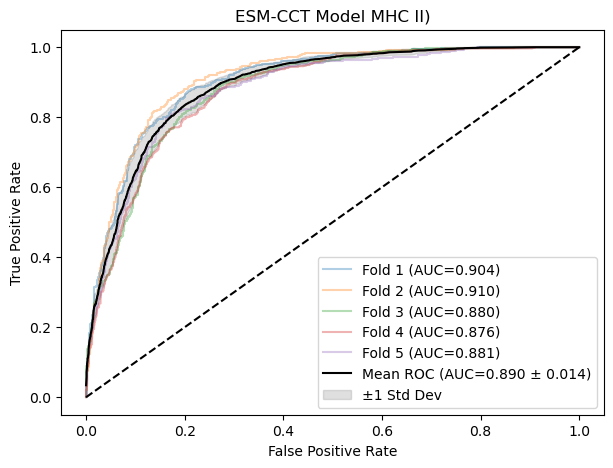

In [29]:

# Collect per-fold FPR/TPR for mean + std calculation
# ----------------------------------------------------
all_fpr = np.unique(np.concatenate([fm["fpr"] for fm in fold_metrics]))
tprs_interpolated = []

for fm in fold_metrics:
    interp_tpr = np.interp(all_fpr, fm["fpr"], fm["tpr"])
    tprs_interpolated.append(interp_tpr)

tprs_interpolated = np.array(tprs_interpolated)

# Mean and STD across folds
mean_tpr = tprs_interpolated.mean(axis=0)
std_tpr = tprs_interpolated.std(axis=0)

mean_auc = auc(all_fpr, mean_tpr)
std_auc = np.std([fm["val_auc"] for fm in fold_metrics])
vals_auc = [fm["val_auc"] for fm in fold_metrics]

# Upper and lower confidence bands (±1 std)
tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
tpr_lower = np.maximum(mean_tpr - std_tpr, 0)

# ----------------------------------------------------
plt.figure(figsize=(7, 5))

# Plot each fold ROC
for fm in fold_metrics:
    plt.plot(fm["fpr"], fm["tpr"], alpha=0.35,
             label=f"Fold {fm['fold']} (AUC={fm['val_auc']:.3f})")

# Plot mean ROC
plt.plot(all_fpr, mean_tpr, color="black", linewidth=1.5,
         label=f"Mean ROC (AUC={mean_auc:.3f} ± {std_auc:.3f})")

# Std shading
plt.fill_between(
    all_fpr,
    tpr_lower,
    tpr_upper,
    color="grey",
    alpha=0.25,
    label="±1 Std Dev"
)

# Diagonal line
plt.plot([0,1],[0,1],'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ESM-CCT Model MHC II)")
plt.legend(loc="lower right")

# Add AUROC stats on plot

plt.show()

# Store final mean-ROC data if needed
mean_roc_data = {
    "all_fpr": all_fpr,
    "mean_tpr": mean_tpr,
    "std_tpr": std_tpr,
    "mean_auc": mean_auc,
    "std_auc": std_auc
}


In [27]:
for idx, layer in enumerate(model.layers):
    print(idx, layer.name, " — ", layer.__class__.__name__)

0 pep_input  —  InputLayer
1 mhc_input  —  InputLayer
2 embedding_2  —  Embedding
3 embedding_3  —  Embedding
4 spatial_dropout1d_2  —  SpatialDropout1D
5 spatial_dropout1d_3  —  SpatialDropout1D
6 conv1d_2  —  Conv1D
7 conv1d_3  —  Conv1D
8 layer_normalization_9  —  LayerNormalization
9 layer_normalization_11  —  LayerNormalization
10 multi_head_attention_4  —  MultiHeadAttention
11 multi_head_attention_5  —  MultiHeadAttention
12 dropout_13  —  Dropout
13 dropout_15  —  Dropout
14 add_4  —  Add
15 add_5  —  Add
16 layer_normalization_10  —  LayerNormalization
17 layer_normalization_12  —  LayerNormalization
18 layer_normalization_13  —  LayerNormalization
19 layer_normalization_14  —  LayerNormalization
20 multi_head_attention_6  —  MultiHeadAttention
21 dropout_17  —  Dropout
22 add_6  —  Add
23 esm_pep_input  —  InputLayer
24 esm_mhc_input  —  InputLayer
25 layer_normalization_15  —  LayerNormalization
26 concatenate_2  —  Concatenate
27 dropout_18  —  Dropout
28 dense_3  —  Dense


In [15]:
# TsNe plots in validation (five fold cv)

In [31]:
from sklearn.manifold import TSNE
# Pick any one fold for visualization
X_pep_val = X_val[0]
X_mhc_val = X_val[1]
X_esm_pep_val = X_val[2]
X_esm_mhc_val = X_val[3]

# ---- Extract important layers ---- example layers
target_layers = [
    "embedding_2",
    "embedding_3",
    "multi_head_attention_6",
    "multi_head_attention_7",
    "dense_3",
    "dense_4"
]

layer_outputs = [model.get_layer(name).output for name in target_layers]

activation_model = Model(inputs=model.inputs, outputs=layer_outputs)

# ---- Forward pass using validation set ----
acts = activation_model.predict(
    [X_pep_val, X_mhc_val, X_esm_pep_val, X_esm_mhc_val],
    batch_size=64
)

print("Number of layers extracted:", len(acts))



2026-01-21 00:07:35.559060: I external/local_xla/xla/service/service.cc:163] XLA service 0x71d05c00f620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-21 00:07:35.559114: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2026-01-21 00:07:35.559124: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (1): Quadro RTX 8000, Compute Capability 7.5
2026-01-21 00:07:35.640444: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-21 00:07:35.860839: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700


21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

I0000 00:00:1768921657.966505 3664711 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step
Number of layers extracted: 6


In [14]:
### tsne_plot

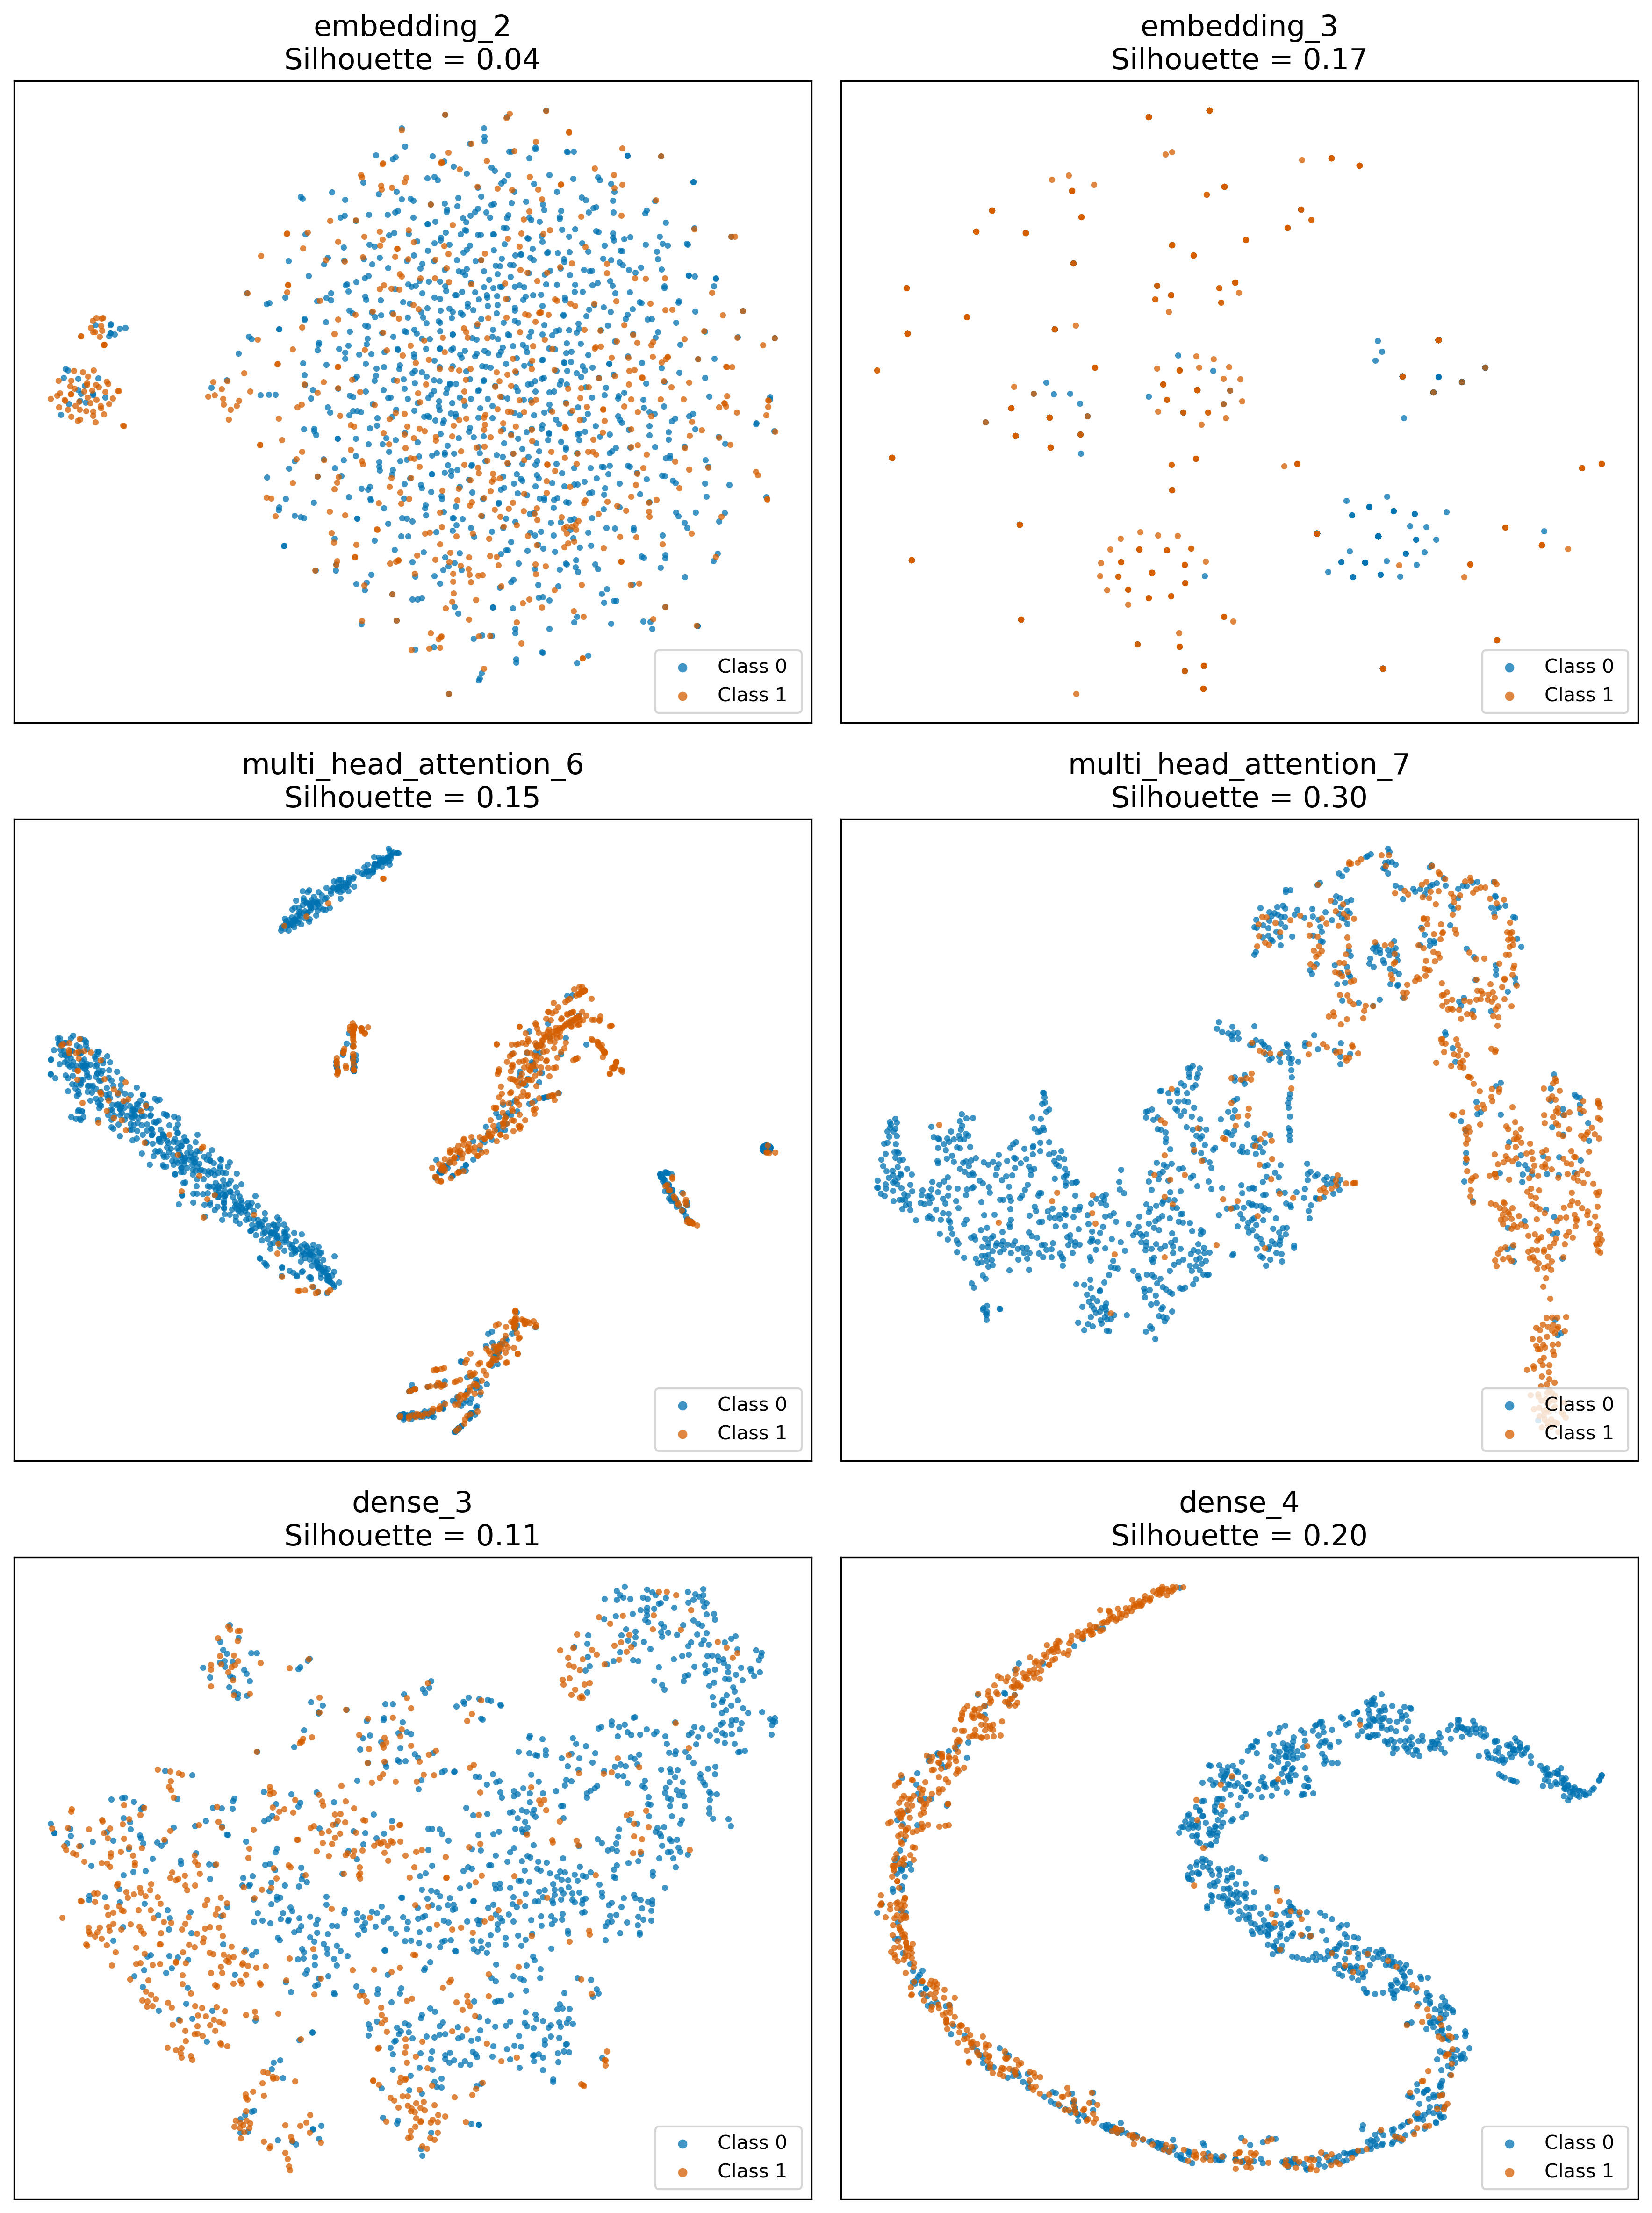

In [32]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "axes.titlesize": 15,
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# Flatten activations (reuse earlier 'acts' variable)
flat_acts = []
for a in acts:
    if len(a.shape) > 2:
        flat = a.reshape(a.shape[0], -1)
    else:
        flat = a
    flat_acts.append(flat)

# validation labels (ensure length matches)
y_vis = y_val[:flat_acts[0].shape[0]]

# color-blind safe colors
color_class0 = "#0072B2"   # blue
color_class1 = "#D55E00"   # vermilion

# t-SNE results + silhouette
tsne_results = []
silhouette_scores = []

for fa in flat_acts:
    fa_std = StandardScaler().fit_transform(fa)

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate=200,
        max_iter=1000,
        init="pca",
        random_state=42
    )

    emb = tsne.fit_transform(fa_std)
    tsne_results.append(emb)

    # silhouette on embedding space
    try:
        score = silhouette_score(emb, y_vis)
    except Exception:
        score = np.nan
    silhouette_scores.append(score)

# Plotting: 3x2 grid, explicit labels for 0 and 1
fig, axs = plt.subplots(3, 2, figsize=(12, 16))
axs = axs.flatten()

for i, emb in enumerate(tsne_results):
    ax = axs[i]
    # class 0
    idx0 = (y_vis == 0)
    ax.scatter(
        emb[idx0, 0], emb[idx0, 1],
        c=color_class0, s=10, alpha=0.75, label=f"Class 0", linewidths=0
    )
    # class 1
    idx1 = (y_vis == 1)
    ax.scatter(
        emb[idx1, 0], emb[idx1, 1],
        c=color_class1, s=10, alpha=0.75, label=f"Class 1 ", linewidths=0 # Immunogenicity = 1,
    )

    ax.set_title(
        f"{target_layers[i]}\nSilhouette = {silhouette_scores[i]:.2f}",
        fontsize=15
    )
    ax.set_xticks([])
    ax.set_yticks([])
    # legend (small)
    ax.legend(frameon=True, fontsize=10, loc="lower right", markerscale=1.5)

plt.tight_layout()

#plt.savefig("tsne_layers_publication_labeled_4.pdf", bbox_inches="tight")
#plt.savefig("tsne_layers_publication_labeled_2.png", bbox_inches="tight", dpi=300)

plt.show()
